## 1. Initialise a controller for starting agent

In [1]:
%autoawait
import time
import asyncio
from aries_basic_controller.aries_controller import AriesAgentController
import time
from termcolor import colored,cprint

WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_BASE = ""

WEBHOOK_PORT = 8032
ADMIN_URL = "http://0.0.0.0:8031"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)

IPython autoawait is `on`, and set to use `asyncio`


## 2. Get a Public DID
Before being able to write to any indy based ledger, your agent must have a public DID written on the ledger giving it the authority to write to it. As the cell below shows, this agent does not currently have a public DID. So any writes to the ledger will be rejected.

In [2]:
response = await agent_controller.wallet.get_public_did()
print(response)

{'result': {'did': 'QJGNPa5MAabxBsu7WQEftG', 'verkey': 'DhV9h6W3NfQMWGqWM1NRJnWrMQjFiqrbNYJokFu1zfSg', 'posture': 'public'}}


In [3]:
## THIS WILL FAIL
schema_id = 'MGgoJXWbeupKsaHDa7s4fW:2:testabc:0.0.1'
response = await agent_controller.definitions.write_cred_def(schema_id)



CancelledError: 


## 3. Generate a new DID

Before being able to write a DID to the ledger, you must create one using the wallet api. This api returns the identifier (the DID), and the verification key for that DID. A representation of it's public key.

In [3]:
# generate new DID
response = await agent_controller.wallet.create_did()

did_object = response['result']
print("New DID", did_object)

New DID {'did': 'ShWekjct3XkxHiFEcj7wm5', 'verkey': 'F1NztiUM7iXKTdof8tqLbCKvYdJKVv39U9fFc1Nb3j7M', 'posture': 'wallet_only'}


## 4. Write DID to Sovrin Stagingnet

Anoyone can write a DID to the Sovrin StagingNet, it is a permissionless ledger.

Visit Sovrin Selfserve Portal for more information. We have provided an automated process to write DIDs to Stagingnet in the step below.


In [4]:
# write new DID to Sovrin Stagingnet
import requests
import json 

url = 'https://selfserve.sovrin.org/nym'

payload = {"network":"stagingnet","did": did_object["did"],"verkey":did_object["verkey"],"paymentaddr":""}

# Adding empty header as parameters are being sent in payload
headers = {}

r = requests.post(url, data=json.dumps(payload), headers=headers)
print(r.json())
print(r.status_code)

{'statusCode': 200, 'headers': {'Access-Control-Allow-Origin': '*'}, 'body': '{"statusCode": 200, "ShWekjct3XkxHiFEcj7wm5": {"status": "Success", "statusCode": 200, "reason": "Successfully wrote NYM identified by ShWekjct3XkxHiFEcj7wm5 to the ledger with role ENDORSER"}}'}
200


## 5. Accepting the Transaction Author Agreement (TAA)

Although the Sovrin StagingNet is permissionless, before DID's have the authority to write to the ledger they must accept something called a transaction author agreement by signing it using the DID they have on the ledger.

In [5]:
# This will not work until you have accepted the TAA
response = await agent_controller.wallet.assign_public_did(did_object["did"])
print(response)

{'result': {'did': 'ShWekjct3XkxHiFEcj7wm5', 'verkey': 'F1NztiUM7iXKTdof8tqLbCKvYdJKVv39U9fFc1Nb3j7M', 'posture': 'public'}}


In [6]:
response = await agent_controller.ledger.get_taa()
TAA = response['result']['taa_record']
TAA['mechanism'] = "service_agreement"
print(TAA)

response = await agent_controller.ledger.accept_taa(TAA)
## Will return {} if successful
print(response)

{'text': '\ufeff# Transaction Author Agreement V2\nhttps://sovrin.org/\n\n\n## Summary:\n\n\nThis summary is provided to help you understand your obligations when writing to\nthe Sovrin Ledger Networks-it does not have any legal effect or replace the full\nlegal text of the agreement provided below it.\n\n\n- This agreement grants you permission to write data to the Sovrin Ledger\n  Networks under certain terms and conditions.\n\n\n- You represent and warrant that the data you are writing does not violate any\n  applicable laws or infringe the rights of any other party.\n\n\n- You understand the data you are writing is public and permanent and there can\n  be no guarantee of erasure. This includes public keys and payment addresses.\n\n\n- If it is determined that the data you wrote violated this agreement, the\n  operators of the network can take steps to block it from public access.\n\n\n- The Sovrin Foundation makes no promises about the reliability or correctness\n  of the data bein

## 6. Set public DID

Now you are able to assign the DID written to the ledger as public

In [7]:
response = await agent_controller.wallet.assign_public_did(did_object["did"])
print(response['result'])

{'did': 'ShWekjct3XkxHiFEcj7wm5', 'verkey': 'F1NztiUM7iXKTdof8tqLbCKvYdJKVv39U9fFc1Nb3j7M', 'posture': 'public'}


In [8]:
##  7. Resolve DID
response = await agent_controller.wallet.get_public_did()
print(response)
issuer_nym = response['result']['did']
print('\nIssuer public DID:',issuer_nym)

issuer_verkey = await agent_controller.ledger.get_did_verkey(issuer_nym)
print(issuer_verkey)

{'result': {'did': 'ShWekjct3XkxHiFEcj7wm5', 'verkey': 'F1NztiUM7iXKTdof8tqLbCKvYdJKVv39U9fFc1Nb3j7M', 'posture': 'public'}}

Issuer public DID: ShWekjct3XkxHiFEcj7wm5
{'verkey': 'F1NztiUM7iXKTdof8tqLbCKvYdJKVv39U9fFc1Nb3j7M'}


In [9]:
# 7. Public Endpoint


## 7. Regular Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [10]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)

## 9. Credential Attributes


In [11]:
name=input("Please enter your name and surname: ")
age=input("Please enter your age: ")
credential_attributes = [
    {"name": "fullname", "value": name},
    {"name": "skill", "value": "PyDentity SSI Ninja"},
    {"name": "age", "value": age}
]
print(credential_attributes)

Please enter your name and surname: Avinash
Please enter your age: 22
[{'name': 'fullname', 'value': 'Avinash'}, {'name': 'skill', 'value': 'PyDentity SSI Ninja'}, {'name': 'age', 'value': '22'}]


In [12]:
## 10. Get Existing Connections

In [13]:

# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS
ConnectionID: f8c453e9-5594-488a-bf07-c75750cca0ac Status: invitation
ConnectionID: 055060af-6b16-4d49-a649-ae26ef794aa5 Status: invitation
ConnectionID: 0b86e558-8d41-499c-88f5-e10f08952c79 Status: invitation


In [14]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection ID 25d8a12d-ae6c-42ad-998f-c6e1742da45a
Invitation
https://24eda79786b0.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiMWNjZjg4NDUtOTliYy00NjA2LTg4NDMtNzQ1ODI2YWQyOTJkIiwgInNlcnZpY2VFbmRwb2ludCI6ICJodHRwczovLzI0ZWRhNzk3ODZiMC5uZ3Jvay5pbyIsICJsYWJlbCI6ICJJU1NVRVIiLCAicmVjaXBpZW50S2V5cyI6IFsiNmZ0YlhQVjNKR2VVeHlobW9GVDJndlZTZUhLRHMxQnhZbnpKZ0dGNXVHekwiXX0=


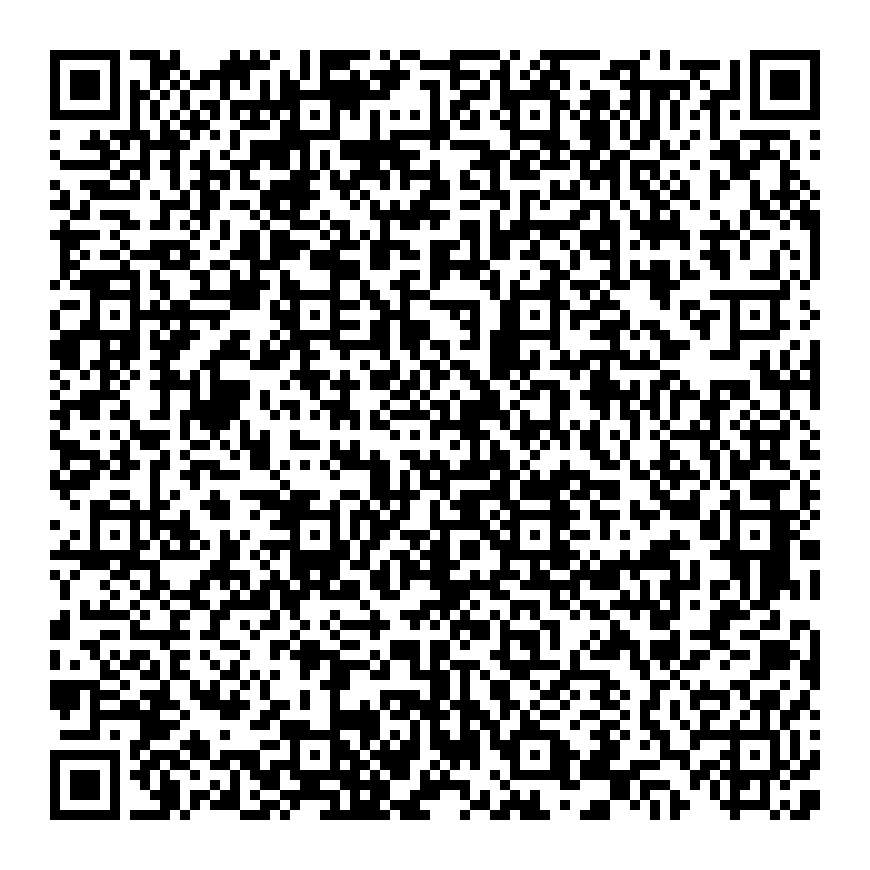

In [15]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

In [16]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))

NameError: name 'STATE' is not defined